# Stress Detection Model:
#### RoBERTa Classifier Adapted on Mental Health Reddit Posts Dataset

In [1]:
train_base = r'domain-adaptation\predictions\train-roberta-base.csv'
test_base = r'domain-adaptation\predictions\test-roberta-base.csv'
train_scr = r'domain-adaptation\predictions\train-roberta-scraped.csv'
test_scr = r'domain-adaptation\predictions\test-roberta-scraped.csv'
train_mh = r'domain-adaptation\predictions\train-roberta-mentalhealth.csv'
test_mh = r'domain-adaptation\predictions\test-roberta-mentalhealth.csv'

In [2]:
import pandas as pd
import numpy as np
import random
import phik
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from empath import Empath

In [3]:
# for reproducibility:
seed = 1
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

set_seed(seed)

## Data preparation

In [4]:
# Prepares training and testing data for classification from given paths
def prepare_data(dataset_path_train = None, dataset_path_test = None, features=None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    X_train = pd.read_csv(dataset_path_train)
    X_test = pd.read_csv(dataset_path_test)
    
    y_train = X_train['label']
    y_test = X_test['label']
        
    X_train = X_train.drop(columns=['label'])
    X_test = X_test.drop(columns=['label'])
    
    
    if features is not None:
        X_train = X_train[features]
        X_test = X_test[features]
    
    return X_train, y_train, X_test, y_test

# Calculates Empath features and adds them to the given dataframe
def empath(X):
    rows = []
    for t in X['text']:
        empath = Empath().analyze(t, normalize=True)
        rows.append(pd.DataFrame([empath]))
    df = pd.concat(rows, ignore_index=True)
    X = pd.concat([X,df], axis=1)
    return X.drop(columns=['text'])

# Returns only lexical features from a given dataframe
def lex(X):
    features = []
    for feat in X.columns.values:
        if 'lex' in feat:
            features.append(feat)
    return features

In [5]:
# Evaluates performance of a model given its predictions on the test set
def evaluate(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred, zero_division=1))
    print("Recall: ", recall_score(y_test, y_pred, zero_division=1))
    print("F1: ", f1_score(y_test, y_pred, zero_division=1))

In [6]:
basic = ['roberta_prediction', 'text'] # for creating Empath features
lexic = lex(pd.read_csv(train_base))
lexic.extend(['roberta_prediction', 'syntax_ari', 'social_karma']) # for getting LIWC features

# LIWC

In [7]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train=train_mh, \
                                                dataset_path_test=test_mh, \
                                                features=lexic)

## Model training and testing
### Logistic Regression
#### Grid search

In [8]:
warnings.filterwarnings('ignore')
hp = {
        'clf__solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'clf__penalty': ['l2', 'elasticnet'],
        'clf__C': [0.1, 1, 10],
}

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, random_state=seed))])

gs_model = GridSearchCV(pipe, hp, n_jobs=-1, scoring='f1')
gs_model.fit(X_train, y_train)
gs_model.best_params_

{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}

#### Testing model with best hyperparameters

In [37]:
model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, C=0.1, penalty='l2', solver='newton-cg', random_state=seed))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8223776223776224
Precision:  0.784037558685446
Recall:  0.9051490514905149
F1:  0.8402515723270441


In [10]:
cdf = pd.DataFrame(model.get_params()['clf'].coef_.transpose(), X_train.columns, columns=['coefficient'])
print(cdf.sort_values(by='coefficient',  key=abs, ascending=False).to_string())

                          coefficient
roberta_prediction           1.941858
lex_liwc_function            0.349715
lex_liwc_tentat              0.293619
lex_liwc_feel                0.283901
lex_liwc_OtherP             -0.256457
lex_liwc_auxverb            -0.254763
lex_liwc_Apostro             0.223892
lex_liwc_differ             -0.221136
lex_liwc_Dic                 0.220886
lex_liwc_death               0.208182
lex_liwc_ipron              -0.202623
lex_liwc_Tone               -0.200016
lex_liwc_swear               0.196680
lex_liwc_anx                 0.195844
lex_liwc_social             -0.193586
lex_liwc_ingest             -0.190344
lex_liwc_Clout              -0.187426
lex_liwc_negemo             -0.187121
lex_dal_avg_pleasantness    -0.174730
lex_liwc_focuspresent        0.174090
lex_dal_min_activation      -0.172090
lex_liwc_certain             0.156947
lex_liwc_percept            -0.155014
lex_dal_min_pleasantness    -0.154411
lex_dal_avg_imagery          0.153001
lex_liwc_art

### Support Vector Machine
#### Grid search

In [11]:
hp = {
        'clf__kernel': ['linear'],
        'clf__gamma': [1000, 100, 10, 1, 0.1, 0.01],
        'clf__C': [0.01, 0.1, 1, 10],
}

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=seed))])

gs_model = GridSearchCV(pipe, hp, n_jobs=-1, scoring='f1')
gs_model.fit(X_train, y_train)
gs_model.best_params_

{'clf__C': 0.01, 'clf__gamma': 1000, 'clf__kernel': 'linear'}

#### Testing model with best hyperparameters

In [12]:
model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(C=0.01, gamma=1000, kernel='linear', random_state=seed))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8181818181818182
Precision:  0.7709750566893424
Recall:  0.9214092140921409
F1:  0.8395061728395061


### Random Forest Classifier
#### Grid search

In [13]:
hp = {
        'clf__n_estimators': [50, 200],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_split': [2, 4]
}

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf',  RandomForestClassifier(random_state=seed))])

gs_model = GridSearchCV(pipe, hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train, y_train)
gs_model.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'clf__criterion': 'entropy',
 'clf__max_features': 'auto',
 'clf__min_samples_split': 4,
 'clf__n_estimators': 200}

#### Testing model with best hyperparameters

In [38]:
model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestClassifier(criterion='entropy', max_features='auto', min_samples_split=4, n_estimators=200, random_state=seed))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8153846153846154
Precision:  0.7736720554272517
Recall:  0.907859078590786
F1:  0.8354114713216958


# Empath

In [15]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train=train_mh, \
                                                dataset_path_test=test_mh, \
                                                features=basic)
X_train = empath(X_train)
X_test = empath(X_test)

## Features Correlation Analysis and Removal

In [16]:
# Determines which features to drop based on the given threshold from phik correlation matrix
def cutoff_features(corr_matrix, threshold):
    upper_tri = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > float(threshold))]
    return to_drop

In [17]:
corrs = X_train.phik_matrix(interval_cols=X_train.columns)

In [18]:
to_drop = cutoff_features(corrs, 0.85)
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
to_drop

['health',
 'banking',
 'night',
 'college',
 'exasperation',
 'reading',
 'worship',
 'eating',
 'water',
 'legend',
 'neglect',
 'swimming',
 'love',
 'sympathy',
 'vehicle',
 'disgust',
 'sound',
 'sailing',
 'warmth',
 'fun',
 'joy',
 'affection',
 'lust',
 'shame',
 'anger',
 'car',
 'technology',
 'power',
 'white_collar_job',
 'party',
 'cleaning',
 'competing',
 'ocean',
 'contentment',
 'musical']

## Model training and testing

### Logistic Regression

#### Grid search

In [19]:
warnings.filterwarnings('ignore')
hp = {
        'clf__solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'clf__penalty': ['l2', 'elasticnet'],
        'clf__C': [0.1, 1, 10],
}

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, random_state=seed))])

gs_model = GridSearchCV(pipe, hp, n_jobs=-1, scoring='f1')
gs_model.fit(X_train, y_train)
gs_model.best_params_

{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

#### Testing model with best hyperparameters

In [20]:
model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, C=0.1, penalty='l2', solver='liblinear', random_state=seed))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8237762237762237
Precision:  0.7845433255269321
Recall:  0.907859078590786
F1:  0.841708542713568


In [21]:
cdf = pd.DataFrame(model.get_params()['clf'].coef_.transpose(), X_train.columns, columns=['coefficient'])
print(cdf.sort_values(by='coefficient',  key=abs, ascending=False).to_string())

                       coefficient
roberta_prediction        2.203177
domestic_work             0.211607
science                   0.198373
tourism                  -0.195794
rage                     -0.172874
prison                   -0.168178
journalism               -0.165871
economics                 0.159455
childish                 -0.156369
kill                      0.144137
order                     0.141765
irritability              0.140860
dance                     0.132753
payment                  -0.131911
heroic                   -0.130906
politeness               -0.127632
computer                 -0.127195
negative_emotion          0.126188
listen                   -0.125875
liquid                    0.123557
nervousness               0.117320
beauty                   -0.116664
family                   -0.116646
disappointment            0.115853
writing                   0.114255
toy                       0.113201
smell                    -0.112839
home                

### Support Vector Machine

#### Grid search

In [22]:
hp = {
        'clf__kernel': ['linear'],
        'clf__gamma': [1000, 100, 10, 1, 0.1, 0.01],
        'clf__C': [0.01, 0.1, 1, 10],
}

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=seed))])

gs_model = GridSearchCV(pipe, hp, n_jobs=-1, scoring='f1')
gs_model.fit(X_train, y_train)
gs_model.best_params_

{'clf__C': 0.01, 'clf__gamma': 1000, 'clf__kernel': 'linear'}

#### Testing model with best hyperparameters

In [23]:
model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(C=0.01, gamma=1000, kernel='linear', random_state=seed))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8181818181818182
Precision:  0.7709750566893424
Recall:  0.9214092140921409
F1:  0.8395061728395061


### Random Forest Classifier

#### Grid search

In [24]:
hp = {
        'clf__n_estimators': [50, 200],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_split': [2, 4]
}

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf',  RandomForestClassifier(random_state=seed))])

gs_model = GridSearchCV(pipe, hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train, y_train)
gs_model.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'clf__criterion': 'entropy',
 'clf__max_features': 'auto',
 'clf__min_samples_split': 2,
 'clf__n_estimators': 200}

#### Testing model with best hyperparameters

In [25]:
model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestClassifier(criterion='entropy', max_features='sqrt', min_samples_split=2, n_estimators=200, random_state=seed))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8153846153846154
Precision:  0.7724137931034483
Recall:  0.9105691056910569
F1:  0.835820895522388


### Comparison with Knežević et al.

In [26]:
X_train_l, y_train, X_test_l, y_test = prepare_data(dataset_path_train=train_base, \
                                                dataset_path_test=test_base, \
                                                features=lexic)

In [27]:
knez_model = LogisticRegression(max_iter=1000000)
knez_model.fit(X_train_l, y_train)
y_pred_l = knez_model.predict(X_test_l)
evaluate(y_test, y_pred_l)

Accuracy:  0.8125874125874126
Precision:  0.7804295942720764
Recall:  0.8861788617886179
F1:  0.8299492385786803


In [28]:
our_model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, C=0.1, penalty='l2', solver='liblinear', random_state=seed))])
our_model.fit(X_train, y_train)
y_pred = our_model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8237762237762237
Precision:  0.7845433255269321
Recall:  0.907859078590786
F1:  0.841708542713568


In [29]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.plotting import checkerboard_plot

def testsig(y_test, y_model1, y_model2, alpha=0.05):
    tb = mcnemar_table(y_target=y_test, 
                   y_model1=y_model1, 
                   y_model2=y_model2)
    brd = checkerboard_plot(tb,
                        figsize=(4, 4),
                        fmt='%d',
                        col_labels=['model 2 correct', 'model 2 incorrect'],
                        row_labels=['model 1 correct', 'model 1 incorrect'])
    
    result = mcnemar(tb, exact=False)
    print('statistic=%.3f, p-value=%.4f' % (result.statistic, result.pvalue))
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

statistic=0.907, p-value=0.3408
Same proportions of errors (fail to reject H0)


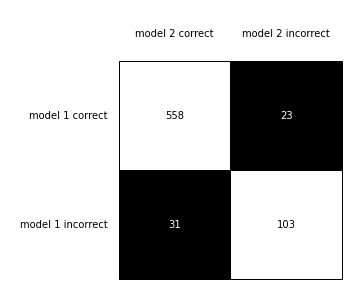

In [30]:
testsig(y_test, y_pred_l, y_pred, alpha=0.05)

Empath features can replace LIWC features.

### Error analysis

In [31]:
indexes = []
predictions = []
for index, (first, second) in enumerate(zip(y_test, y_pred)):
    if first != second:
        indexes.append(index)
        predictions.append(second)
        
indexes2 = []
predictions2 = []
for index, (first, second) in enumerate(zip(y_test, y_pred_l)):
    if first != second:
        indexes2.append(index)
        predictions2.append(second)

In [32]:
sum(predictions)/len(predictions)

0.7301587301587301

In [33]:
sum(predictions2)/len(predictions2)

0.6865671641791045

In [34]:
test_ex = pd.read_csv(train_base)[['text', 'label']]
for i in indexes:
    if i not in indexes2:
        print(test_ex.loc[[i]].to_string())

                                                                                                                                text  label
72  I don’t know. Was this okay? Should I hate him? Or was it just something new? I really don’t know what to make of the situation.      1
                                                                                                                                                                                                                                                                                                                         text  label
89  We are 100% no contact, and have decided we won't talk to each other for at least a few months, or until we're ready to talk and maybe try to be friends. He says he still cares deeply for me and loves me, but this is for the best. I wish it was easier to get over, but it isn't. What advice do y'all have? Thanks!      0
                                                                      

In [35]:
test_ex = pd.read_csv(test_base)[['text', 'label']]
for i in indexes2:
    if i not in indexes:
        print(test_ex.loc[[i]].to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  label
18  If I go to an interview for example, I'll know that I'm a good candidate, I'll know that if I don't get it there will always be other opportunities and it's no big deal. Yet I still get nervous because it's something that I want, I want that employer to like me. If I go to an interview with no expectations at all, not even wanting the job (I've done this a few times for pr

In [36]:
inter = np.intersect1d(indexes, indexes2)
suma = 0
for i in inter:
    print(test_ex.loc[[i]].to_string())
    suma += test_ex['label'].iloc[i]

                                                                                                                                                                                                                                                                                                                                                                           text  label
12  PTSD is life changing for the worse. Every day fight. Getting in a fist fight in high school( who did not get into a fight)  I'm not talking about bullying,  Playing video games,  having bad dreams does not cause PTSD. We have seen things, or done things or ,been part of things,  that most people will never understand and hopefully never experience. End of Rant      1
                                                                                                                                                                                                                                                          

                                                                                                                                                                                                                                                                                                                                                                                    text  label
605  I've got a good handle on my triggers. I know how to prepare myself when I have to encounter a trigger and how to move past it without too much discomfort. That being said today I encountered an event that blindsided me. I was not prepared at all. I know its possible I will come across triggers without warning, but this was something that had not been a trigger before.      1
                                                                                                                                                                                                                                        